In [4]:
# Import libraries

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, desc, asc, sum as Fsum
from pyspark.sql.types import StringType, IntegerType
import datetime
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt


In [5]:
# Create SparkSession

spark = (SparkSession
         .builder
         .appName("Data Wrangling")
         .getOrCreate())

In [6]:
# Read file

path = "../data/sparkify_log_small.json"
user_log_df = spark.read.json(path)

In [7]:
user_log_df.take(5)

[Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046'),
 Row(artist='Lily Allen', auth='Logged In', firstName='Elizabeth', gender='F', itemInSession=7, lastName='Chase', length=195.23873, level='free', location='Shreveport-Bossier City, LA', method='PUT', page='NextSong', registration=1512718541284, sessionId=5027, song='Cheryl Tweedy', status=200, ts=1513720878284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1000'),
 Row(artist='Cobra Starship Featuring Leighton Meester', auth='Logged In', firstNa

In [8]:
user_log_df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [9]:
user_log_df.describe().show()

+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|summary|           artist|      auth|firstName|gender|     itemInSession|lastName|           length|level|    location|method|   page|        registration|         sessionId|    song|           status|                 ts|           userAgent|            userId|
+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|  count|             8347|     10000|     9664|  9664|             10000|    9664|             8347|10000|        9664| 10000|  10000|                9664|             10000|    8347|            10000|         

In [10]:
print(user_log_df.count())    

10000


In [11]:
# Select the page column, drop the duplicates, and sort by page

user_log_df.select("page").dropDuplicates().sort("page").show()

+----------------+
|            page|
+----------------+
|           About|
|       Downgrade|
|           Error|
|            Help|
|            Home|
|           Login|
|          Logout|
|        NextSong|
|   Save Settings|
|        Settings|
|Submit Downgrade|
|  Submit Upgrade|
|         Upgrade|
+----------------+



In [12]:
# Select data for all pages where userId is 1046

(user_log_df
 .select(["userId", "firstname", "page", "song"])
 .where(user_log_df.userId == "1046")
 .show())

+------+---------+--------+--------------------+
|userId|firstname|    page|                song|
+------+---------+--------+--------------------+
|  1046|  Kenneth|NextSong|Christmas Tears W...|
|  1046|  Kenneth|NextSong|  Be Wary Of A Woman|
|  1046|  Kenneth|NextSong|   Public Enemy No.1|
|  1046|  Kenneth|NextSong|Reign Of The Tyrants|
|  1046|  Kenneth|NextSong|      Father And Son|
|  1046|  Kenneth|NextSong|               No. 5|
|  1046|  Kenneth|NextSong|           Seventeen|
|  1046|  Kenneth|    Home|                null|
|  1046|  Kenneth|NextSong|          War on war|
|  1046|  Kenneth|NextSong|   Killermont Street|
|  1046|  Kenneth|NextSong|        Black & Blue|
|  1046|  Kenneth|  Logout|                null|
|  1046|  Kenneth|    Home|                null|
|  1046|  Kenneth|NextSong|     Heads Will Roll|
|  1046|  Kenneth|NextSong|Bleed It Out [Liv...|
|  1046|  Kenneth|NextSong|              Clocks|
|  1046|  Kenneth|NextSong|           Love Rain|
|  1046|  Kenneth|Ne

In [13]:
# Calculating Statistics by Hour

get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
user_log_df = user_log_df.withColumn("hour", get_hour(user_log_df.ts))

In [14]:
user_log_df.take(1)

[Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='20')]

In [15]:
# Select just the NextSong page

songs_in_hour_df = (
    user_log_df.filter(user_log_df.page == "NextSong")
    .groupby(user_log_df.hour)
    .count()
    .orderBy(user_log_df.hour.cast("float"))
    )

In [16]:
songs_in_hour_df.show()

+----+-----+
|hour|count|
+----+-----+
|   0|  382|
|   1|  302|
|   2|  352|
|   3|  276|
|   4|  348|
|   5|  358|
|   6|  375|
|   7|  249|
|   8|  216|
|   9|  228|
|  10|  251|
|  11|  339|
|  12|  462|
|  13|  479|
|  14|  484|
|  15|  430|
|  16|  362|
|  17|  295|
|  18|  257|
|  19|  248|
+----+-----+
only showing top 20 rows



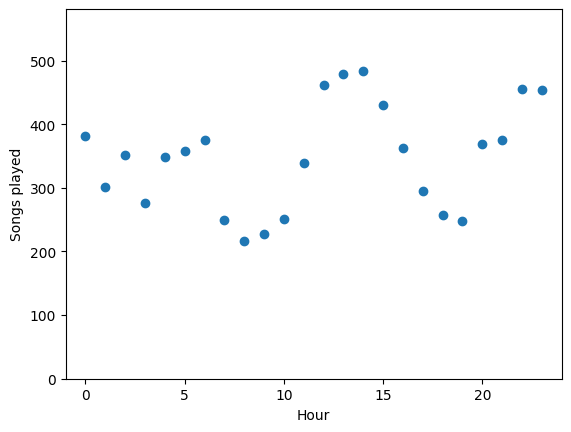

In [17]:
songs_in_hour_pd = songs_in_hour_df.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24)
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played")
plt.show()

In [18]:
# # Drop Rows with Missing Values
# 
# As you'll see, it turns out there are no missing values in the userID or session columns. But there are userID values that are empty strings.

user_log_valid_df = user_log_df.dropna(how = "any", subset = ["userId", "sessionId"])
user_log_valid_df.count()

10000

In [19]:
# Select all unique user ids into a dataframe

(user_log_df.select("userId")
 .dropDuplicates()
 .sort("userId").show())


+------+
|userId|
+------+
|      |
|    10|
|   100|
|  1000|
|  1003|
|  1005|
|  1006|
|  1017|
|  1019|
|  1020|
|  1022|
|  1025|
|  1030|
|  1035|
|  1037|
|   104|
|  1040|
|  1042|
|  1043|
|  1046|
+------+
only showing top 20 rows



In [20]:
# Select only data for where the userId column isn't an empty string (different from null)

user_log_valid_df = user_log_df.filter(user_log_df.userId != "")


In [21]:
user_log_valid_df.count()

9664

In [22]:
# # Users Downgrade Their Accounts
# 
# Find when users downgrade their accounts and then show those log entries. 

user_log_valid_df.filter("page = 'Submit Downgrade'").show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|hour|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|  null|Logged In|    Kelly|     F|           24|  Newton|  null| paid|Houston-The Woodl...|   PUT|Submit Downgrade|1513283366284|     5931|null|   307|1513768454284|Mozilla/5.0 (Wind...|  1138|   9|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+


In [23]:
(user_log_df
 .select(["userId", "firstname", "page", "level", "song"])
 .where(user_log_df.userId == "1138")
 .show())

+------+---------+--------+-----+--------------------+
|userId|firstname|    page|level|                song|
+------+---------+--------+-----+--------------------+
|  1138|    Kelly|    Home| paid|                null|
|  1138|    Kelly|NextSong| paid| Everybody Everybody|
|  1138|    Kelly|NextSong| paid|               Gears|
|  1138|    Kelly|NextSong| paid|        Use Somebody|
|  1138|    Kelly|NextSong| paid|Love Of My Life (...|
|  1138|    Kelly|NextSong| paid|Down In The Valle...|
|  1138|    Kelly|NextSong| paid|Treat Her Like A ...|
|  1138|    Kelly|NextSong| paid|Everybody Thinks ...|
|  1138|    Kelly|NextSong| paid|      Fourteen Wives|
|  1138|    Kelly|NextSong| paid|   Love On The Rocks|
|  1138|    Kelly|NextSong| paid|           Breakeven|
|  1138|    Kelly|NextSong| paid|          Leaf House|
|  1138|    Kelly|NextSong| paid|       NAISEN KANSSA|
|  1138|    Kelly|NextSong| paid|  You're In My Heart|
|  1138|    Kelly|NextSong| paid|Roll On Down The ...|
|  1138|  

In [24]:
# Create a user defined function to return a 1 if the record contains a downgrade

flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

In [25]:
user_log_valid_df = (user_log_valid_df
                     .withColumn("downgraded", flag_downgrade_event("page")))

In [26]:
print(
    user_log_valid_df.head()
)

Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='20', downgraded=0)


In [27]:
from pyspark.sql import Window


In [28]:
# Partition by user id
# Then use a window function and cumulative sum to distinguish each user's data as either pre or post downgrade events.

windowval = (Window.partitionBy("userId")
             .orderBy(desc("ts"))
             .rangeBetween(Window.unboundedPreceding, 0))

In [29]:
# Fsum is a cumulative sum over a window - in this case a window showing all events for a user
# Add a column called phase, 0 if the user hasn't downgraded yet, 1 if they have

user_log_valid_df = (user_log_valid_df
                     .withColumn("phase", Fsum("downgraded").over(windowval)))

In [30]:
user_log_valid_df.show()

+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----+----------+-----+
|           artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|hour|downgraded|phase|
+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----+----------+-----+
|  The Get Up Kids|Logged In| Veronica|     F|            0| Buckley|178.59873| free|Detroit-Warren-De...|   PUT|NextSong|1512966806284|     6676|             Overdue|   200|1513828388284|"Mozilla/5.0 (Mac...|    10|   1|         0|    0|
|      OneRepublic|Logged In| Veronica|     

In [31]:
# Show the phases for user 1138 
user_log_valid_df \
    .select(["userId", "firstname", "ts", "page", "level", "phase"]) \
    .where(user_log_df.userId == "1138") \
    .sort("ts") \
    .show()

+------+---------+-------------+--------+-----+-----+
|userId|firstname|           ts|    page|level|phase|
+------+---------+-------------+--------+-----+-----+
|  1138|    Kelly|1513729066284|    Home| paid|    1|
|  1138|    Kelly|1513729066284|NextSong| paid|    1|
|  1138|    Kelly|1513729313284|NextSong| paid|    1|
|  1138|    Kelly|1513729552284|NextSong| paid|    1|
|  1138|    Kelly|1513729783284|NextSong| paid|    1|
|  1138|    Kelly|1513730001284|NextSong| paid|    1|
|  1138|    Kelly|1513730263284|NextSong| paid|    1|
|  1138|    Kelly|1513730518284|NextSong| paid|    1|
|  1138|    Kelly|1513730768284|NextSong| paid|    1|
|  1138|    Kelly|1513731182284|NextSong| paid|    1|
|  1138|    Kelly|1513731435284|NextSong| paid|    1|
|  1138|    Kelly|1513731695284|NextSong| paid|    1|
|  1138|    Kelly|1513731857284|NextSong| paid|    1|
|  1138|    Kelly|1513732160284|NextSong| paid|    1|
|  1138|    Kelly|1513732302284|NextSong| paid|    1|
|  1138|    Kelly|1513732540

In [56]:
# How many female users do we have in the data set?
from pyspark.sql.functions import countDistinct

(user_log_valid_df
 .groupBy("gender")
 .agg(countDistinct("userId"))
 .show())

+------+-------------+
|gender|count(userId)|
+------+-------------+
|     F|          462|
|     M|          501|
+------+-------------+



In [62]:
# How many songs were played from the most played artist?
from pyspark.sql.functions import col

(user_log_valid_df
 .select(col("artist"))
 .groupBy(col("artist"))
 .count()
 .sort(col("count").desc())
 .show())

(user_log_valid_df
 .filter(col("artist") == "Coldplay")
 .groupBy(col("artist"))
 .count()
 .show())

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|                null| 1317|
|            Coldplay|   83|
|       Kings Of Leon|   69|
|Florence + The Ma...|   52|
|            BjÃÂ¶rk|   46|
|       Dwight Yoakam|   45|
|       Justin Bieber|   43|
|      The Black Keys|   40|
|         OneRepublic|   37|
|        Jack Johnson|   36|
|                Muse|   36|
|           Radiohead|   31|
|        Taylor Swift|   29|
|Barry Tuckwell/Ac...|   28|
|          Lily Allen|   28|
|               Train|   28|
|           Metallica|   27|
|           Daft Punk|   27|
|          Nickelback|   27|
|          Kanye West|   26|
+--------------------+-----+
only showing top 20 rows

+--------+-----+
|  artist|count|
+--------+-----+
|Coldplay|   83|
+--------+-----+



In [ ]:
# How many songs do users listen to on average between visiting our home page? Please round your answer to the closest integer.